# Practical 3: CIFAR-10

This is the second task of Practical 3. Your task is to use **transfer learning** to build a convolutional neural network to tackle the CIFAR-10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). 
You could select an existing trained model (VGG16 excluded) from Keras (https://keras.io/api/applications/) and fine-tune it to build a classifier for CIFAR-10.

We will grade your code based on the accuracy of your model. 
Your CNN should achieve at least an accuracy of 75% to pass the practical.
You can get 5 bonus points by achieving an accuracy of 85%+.


The model files might be too large to be uploaded to GitHub. 
Please use the following link to upload your models: https://seafile.ifi.uzh.ch/u/d/695f63e725b641ed8633/

Name the model file `{repository_name}-CIFAR10.h5`. For example, if your repository is FDS22-M0, you should name the model file `FDS22-M0-CIFAR10.h5`. If you are not satisfied with the model you have uploaded, you can upload a new one with the same name. We will only look at the newest model. Nevertheless, try to upload as few times as possible, since the online drive has a limited amount of space. 

## Import the libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

In [ ]:
tf.__version__

In [ ]:
tf.keras.__version__

'2.9.0'

## Prepare the dataset

In this block, you will prepare the data for the training, such as apply the preprocess function of your selected model and perform data augmentation. 

170498071/170498071 [==============================] - 2s 0us/step


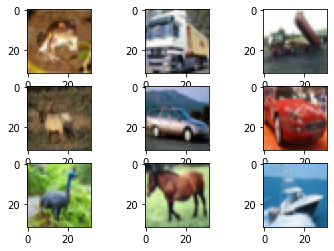

(50000, 32, 32, 3)

In [4]:
from keras.datasets import cifar10
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train_full[i])
plt.show()

X_train_full.shape

## Build and train the model

Build and train your model. 

In [5]:
# one-hot encoding
y_train_full = keras.utils.to_categorical(y_train_full, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

# normalisation
X_train_full = X_train_full/255.0
X_test = X_test/255.0
print(X_train_full.shape)

# get validation dataset
np.random.seed(42) # we set the random seed to make sure everytime the data is shuffled in the same way 
shuffled_indices = np.random.permutation(X_train_full.shape[0])
X_valid, X_train = X_train_full[shuffled_indices[:5000]], X_train_full[shuffled_indices[5000:]]
y_valid, y_train = y_train_full[shuffled_indices[:5000]], y_train_full[shuffled_indices[5000:]]

(50000, 32, 32, 3)


In [ ]:
# TODO: load the model you selected
model_transfer = tf.keras.applications.VGG19(include_top=False, input_shape=(32, 32, 3), weights='imagenet')
model_transfer.summary()



Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
# TODO: Transfer learning - build your own model based on the selected model
x = model_transfer.layers[-6].output

# x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Flatten()(x)

x = keras.layers.Dense(1024, activation='relu')(x) # dense layer 1
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.3)(x)

x = keras.layers.Dense(512, activation='relu')(x) # dense layer 2
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.3)(x)

output = keras.layers.Dense(10, activation='softmax')(x) 

model = keras.Model(inputs=model_transfer.input, outputs=output)

# freeze the layers
for layer in model_transfer.layers:
    layer.trainable=False

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
model.compile(
              optimizer=keras.optimizers.Adam(),
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=20, horizontal_flip=True, zoom_range=0.1)
train_data_generator = datagen.flow(X_train, y_train, batch_size=32)

history = model.fit(
    # train_data_generator, 
    X_train, y_train,
                    batch_size=32, epochs=20, 
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb],
                    )

Epoch 1/20
1407/1407 [==============================] - 604s 428ms/step - loss: 1.1685 - accuracy: 0.6123 - val_loss: 0.9102 - val_accuracy: 0.6862
Epoch 2/20
1407/1407 [==============================] - 599s 426ms/step - loss: 0.9012 - accuracy: 0.6863 - val_loss: 0.8226 - val_accuracy: 0.7214
Epoch 3/20
1407/1407 [==============================] - 599s 426ms/step - loss: 0.8466 - accuracy: 0.7059 - val_loss: 0.7800 - val_accuracy: 0.7292
Epoch 4/20
1407/1407 [==============================] - 595s 423ms/step - loss: 0.8028 - accuracy: 0.7191 - val_loss: 0.7956 - val_accuracy: 0.7294
Epoch 5/20
1407/1407 [==============================] - 607s 432ms/step - loss: 0.7693 - accuracy: 0.7318 - val_loss: 0.7447 - val_accuracy: 0.7380
Epoch 6/20
1407/1407 [==============================] - 600s 427ms/step - loss: 0.7384 - accuracy: 0.7398 - val_loss: 0.7645 - val_accuracy: 0.7386
Epoch 7/20
1407/1407 [==============================] - 597s 424ms/step - loss: 0.7122 - accuracy: 0.7486 - val_

In [ ]:
# show the structure of your model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

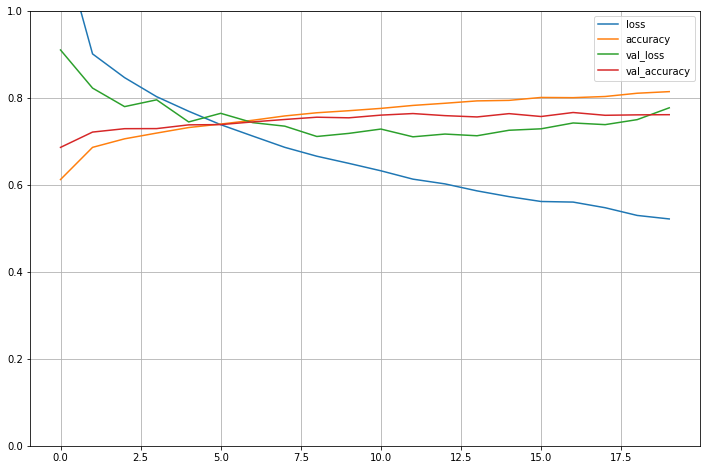

In [ ]:
# Assume you have stored the training history in the variable "history"
# Show the learning curves
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.gca().set_ylim(0, 1)
plt.grid(True)
plt.show()

## Save the model

Save and upload your trained model to the **Seafile link** we provided to you. You can upload it multiple times. We will consider only the newest uploaded model. 

In [ ]:
model.save('FDS22-M133-CIFAR10.h5') # change the file name according to your repository name

## Load the model and evaluate it on the test data

In [6]:
model = keras.models.load_model('FDS22-M133-CIFAR10.h5')
model.evaluate(X_test, y_test)

313/313 [==============================] - 139s 442ms/step - loss: 0.7575 - accuracy: 0.7533


[0.7575228810310364, 0.7533000111579895]

## Short report

Please write a few sentences explaining how you build and train the model. Please include the decisions you made, such as how you decide the number of layers reused from the selected model and the difficulties you met.

**Explanation**
I removed the last 6 layers of VGG19 and added some layers (FC, Hidden layers). Since the dimensionality is large, I chose 1024 and 512 as output space in order to keep enough information.

**Difficulties**
The model's prediction capability fluctuates between 74.85%-76.91%. I tried many methods to increase the accuracy but couldn't wrap my mind around. I have tried:  
(1) apply data argumentation (only bring slight improvement)  
(2) add dropout layers after MaxPooling layer; redesign Conv-Pool structure  
(3) change batch size. Small batch size might bring unstable gradients.  
(4) modify optimizer method (adam, SGD)  
